In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ricardosalvatorelli1/paddydoctor")

print("Path to dataset files:", path)

100%|██████████| 1.02G/1.02G [00:47<00:00, 22.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1


In [2]:
import os
import shutil
from pathlib import Path

# Paths
source_folder = '/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images'  # Replace with your source dataset folder
destination_folder ="test_images"
images_per_class = 50  # Number of images to copy per class

# Create the destination folder
os.makedirs(destination_folder, exist_ok=True)

# Iterate through each class folder
for class_name in os.listdir(source_folder):
    class_path = os.path.join(source_folder, class_name)
    if os.path.isdir(class_path):  # Check if it's a folder
        # Create a corresponding folder in the destination
        dest_class_folder = os.path.join(destination_folder, class_name)
        os.makedirs(dest_class_folder, exist_ok=True)

        # Get all image files in the class folder
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        # Sort images to maintain order and select the first 50
        selected_images = images[:images_per_class]

        # Copy selected images to the destination folder
        for img_name in selected_images:
            src = os.path.join(class_path, img_name)
            dest = os.path.join(dest_class_folder, img_name)
            shutil.copy(src, dest)

print(f"Test dataset created successfully in '{destination_folder}'")


Test dataset created successfully in 'test_images'


In [3]:
import glob
from pathlib import Path

train_path = '/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images/'
test_path  = 'test_images'

print('train images')
for filepath in glob.glob(train_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

print('test images')
for filepath in glob.glob(test_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

files = glob.glob(test_path + '/*')
print(f"{len(files)} \t {Path(test_path).name}")

train images
1738 	 blast
337 	 bacterial_panicle_blight
965 	 brown_spot
1088 	 tungro
1764 	 normal
1442 	 dead_heart
380 	 bacterial_leaf_streak
1594 	 hispa
479 	 bacterial_leaf_blight
620 	 downy_mildew
test images
50 	 blast
50 	 bacterial_panicle_blight
50 	 brown_spot
50 	 tungro
50 	 normal
50 	 dead_heart
50 	 bacterial_leaf_streak
50 	 hispa
50 	 bacterial_leaf_blight
50 	 downy_mildew
10 	 test_images


In [4]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import cv2
# import tensorflow_addons as tfa
import albumentations as A

from albumentations.core.composition import Compose
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Add, Activation
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten

from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array, array_to_img

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
SEED = 123
EPOCHS = 50
lr = 1e-4
valid_split = 0.2
input_size = 224
batch_size = 32

n_classes = len(glob.glob(train_path + '/*/'))
print(n_classes)

10


In [6]:
generator = ImageDataGenerator(rescale=1 / 255,
                                  rotation_range=10,
                                  shear_range=0.25,
                                  zoom_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  validation_split=valid_split,
#                                   preprocessing_function=get_transforms_train
                                 )

train_datagen = generator.flow_from_directory(train_path,
                                              target_size=(input_size, input_size),
                                              batch_size=batch_size,
                                              subset='training',
                                              seed=SEED)

valid_datagen = generator.flow_from_directory(train_path,
                                              target_size=(input_size, input_size),
                                              batch_size=batch_size,
                                              subset='validation',
                                              seed=SEED)

test_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(directory=test_path,
                                                                    target_size=(input_size, input_size),
                                                                    batch_size=batch_size,
                                                                    #classes=['.'],
                                                                    shuffle=False,
                                                                    seed=SEED
                                                                   )

print(train_datagen.class_indices)
print(train_datagen.samples, valid_datagen.samples, test_generator.samples, )

Found 8330 images belonging to 10 classes.
Found 2077 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}
8330 2077 500


In [7]:
def create_model(input_size, n_classes):
    back_bone = tf.keras.applications.Xception(weights='imagenet', input_shape=(input_size,input_size,3), include_top=False)
    back_bone.summary()
    # tf.keras.utils.plot_model(back_bone, to_file='xception.png',show_shapes=False, show_layer_names=False)
    input_layer = Input(shape=(input_size,input_size,3))
    x = back_bone(input_layer)
    x = GlobalAveragePooling2D()(x)
    output_layer = Dense(n_classes, activation='softmax')(x)

    initializer = tf.keras.initializers.HeUniform()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = tf.keras.losses.categorical_crossentropy

    model = Model(input_layer,output_layer)
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    return model

model = create_model(input_size, n_classes)
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,881,970 (79.66 MB)

 Trainable params: 20,827,442 (79.45 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [8]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=15,
                                              monitor='val_loss',
                                              restore_best_weights=True,
                                              verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=5,
                                                 monitor='val_loss',
                                                 factor=0.75,
                                                 verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='xception.weights.best.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True
)
# checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='xception.weights.best.hdf5',
#                                                 monitor='val_loss',
#                                                 verbose=1,
#                                                 save_best_only=True)

In [9]:
history = model.fit(train_datagen,
                    validation_data=valid_datagen,
                    batch_size=batch_size,
                    epochs=EPOCHS,
                    callbacks=[early_stop,reduce_lr, checkpoint])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.4639 - loss: 1.5852
Epoch 1: val_loss improved from inf to 0.69081, saving model to xception.weights.best.keras
261/261 ━━━━━━━━━━━━━━━━━━━━ 271s 816ms/step - accuracy: 0.4646 - loss: 1.5835 - val_accuracy: 0.7626 - val_loss: 0.6908 - learning_rate: 1.0000e-04
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.8424 - loss: 0.5005
Epoch 2: val_loss improved from 0.69081 to 0.35957, saving model to xception.weights.best.keras
261/261 ━━━━━━━━━━━━━━━━━━━━ 193s 687ms/step - accuracy: 0.8424 - loss: 0.5003 - val_accuracy: 0.8859 - val_loss: 0.3596 - learning_rate: 1.0000e-04
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.9176 - loss: 0.2627
Epoch 3: val_loss improved from 0.35957 to 0.26227, saving model to xception.weights.best.keras
261/261 ━━━━━━━━━━━━━━━━━━━━ 196s 736ms/step - accuracy: 0.9176 - loss: 0.2626 - val_accuracy: 0.9191 - val_loss: 0.2623 - learning_rate: 1.0000e-04
Epoch 4/50
261/2

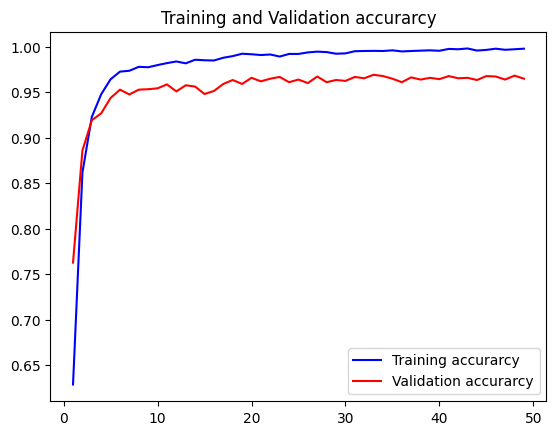

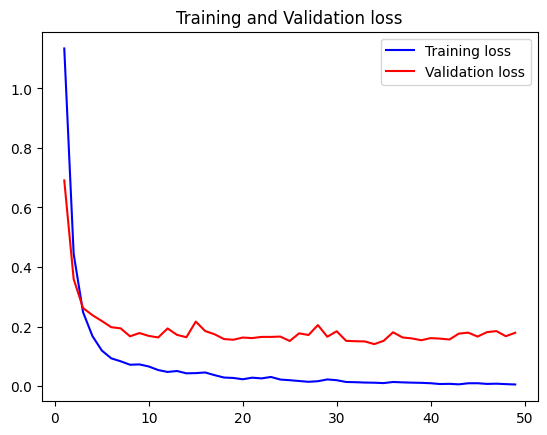

CPU times: user 424 ms, sys: 240 ms, total: 664 ms
Wall time: 407 ms


In [18]:
%%time
temp = pd.DataFrame(history.history)
temp.to_csv('model_xception_history.csv', index=False)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [19]:
print('test images')
for filepath in glob.glob(test_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory=test_path,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    #classes=['.'],
    #class_mode="categorical",
    class_mode=None,
    shuffle=False,
    seed=SEED)

test images
50 	 blast
50 	 bacterial_panicle_blight
50 	 brown_spot
50 	 tungro
50 	 normal
50 	 dead_heart
50 	 bacterial_leaf_streak
50 	 hispa
50 	 bacterial_leaf_blight
50 	 downy_mildew
Found 500 images belonging to 10 classes.


In [20]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()

model.load_weights('xception.weights.best.keras')
pred = model.predict(test_generator,
                               steps=STEP_SIZE_TEST,
                               verbose=1)
pred_classes = np.argmax(pred, axis=1)

 16/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step


In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

class_names = test_generator.class_indices.keys()
true_classes = test_generator.classes

acc = accuracy_score(true_classes, pred_classes)
print("xception Model Accuracy : {:.2f}%".format(acc * 100))

cls_report = classification_report(true_classes, pred_classes,
                                   target_names=class_names, digits=5)
print(cls_report)

xception Model Accuracy : 99.40%
                          precision    recall  f1-score   support

   bacterial_leaf_blight    1.00000   1.00000   1.00000        50
   bacterial_leaf_streak    1.00000   1.00000   1.00000        50
bacterial_panicle_blight    1.00000   0.96000   0.97959        50
                   blast    0.98039   1.00000   0.99010        50
              brown_spot    1.00000   1.00000   1.00000        50
              dead_heart    0.96154   1.00000   0.98039        50
            downy_mildew    1.00000   1.00000   1.00000        50
                   hispa    1.00000   0.98000   0.98990        50
                  normal    1.00000   1.00000   1.00000        50
                  tungro    1.00000   1.00000   1.00000        50

                accuracy                        0.99400       500
               macro avg    0.99419   0.99400   0.99400       500
            weighted avg    0.99419   0.99400   0.99400       500



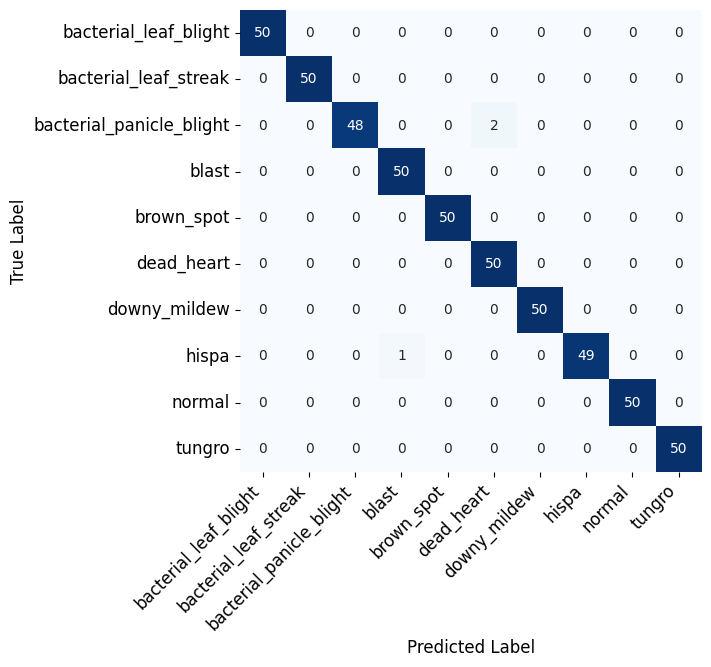

[[50  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0]
 [ 0  0 48  0  0  2  0  0  0  0]
 [ 0  0  0 50  0  0  0  0  0  0]
 [ 0  0  0  0 50  0  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  1  0  0  0 49  0  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0  0 50]]


In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_heatmap(true_classes, pred_classes, class_names, ax, title="CNN")

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()
cm = confusion_matrix(true_classes, pred_classes)
print(cm)

In [23]:
loss, acc = model.evaluate(valid_datagen, steps=STEP_SIZE_TEST, verbose=1)
print(acc, loss)

500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - accuracy: 0.9690 - loss: 0.1565  


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


0.9696677923202515 0.15732930600643158


In [24]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_datagen.class_indices)

labels = (train_datagen.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

pd.Series(predictions).value_counts()

,count
dead_heart,52
blast,51
bacterial_leaf_streak,50
bacterial_leaf_blight,50
brown_spot,50
downy_mildew,50
tungro,50
normal,50
hispa,49
bacterial_panicle_blight,48


In [25]:
filenames=test_generator.filenames

results=pd.DataFrame({"image_id":filenames,
                      "label":predictions})
results.image_id = results.image_id.str.replace('./', '')
results.to_csv("submission.csv",index=False)
results.head()

,image_id,label
0,bacterial_leaf_blight/100582.jpg,bacterial_leaf_blight
1,bacterial_leaf_blight/100681.jpg,bacterial_leaf_blight
2,bacterial_leaf_blight/100956.jpg,bacterial_leaf_blight
3,bacterial_leaf_blight/101394.jpg,bacterial_leaf_blight
4,bacterial_leaf_blight/101485.jpg,bacterial_leaf_blight
